In [2]:
!pip install -U openassetpricing

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 9.0 MB/s eta 0:00:00a 0:00:01m
  Created wheel for psycopg2-binary: filename=psycopg2_binary-2.9.10-cp312-cp312-macosx_11_0_arm64.whl size=134518 sha256=7f37c325af118813afd165c85ffd27b9520cea819a7ed7cb35d49302227e5153
  Stored in directory: /Users/mamamia/Library/Caches/pip/wheels/06/bc/a4/bad5bdabd4cf012a00e927db042e0e44d3a649596c548212be
Successfully built psycopg2-binary


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
from datetime import datetime
import openassetpricing as openap

# -------------------- Parameters --------------------
signallist = ['IndIPO','BM']

# -------------------- Initialize OpenAP and Download Signal Doc --------------------
openap_obj = openap.OpenAP()  
signaldoc = openap_obj.dl_signal_doc('pandas')

print("Available signals:")
print(signaldoc[['Acronym', 'Authors', 'LongDescription']].head(20))

# -------------------- Download Portfolio Data --------------------
# Download OSAP portfolio returns for the IndIPO signal
port_osap = openap_obj.dl_port('op', 'pandas', signallist)
port_osap['date'] = pd.to_datetime(port_osap['date'])

# Reduce to LS portfolios (openap provides multiple portfolio versions for each anomaly on each date)
port_osap.query('port== "LS"', inplace=True)

display(port_osap.groupby('signalname').describe()['ret'])


Available signals:
               Acronym                         Authors  \
0     AbnormalAccruals                             Xie   
1             Accruals                           Sloan   
2           AccrualsBM                  Bartov and Kim   
3            Activism1                Cremers and Nair   
4                   AM                 Fama and French   
5      AnalystRevision     Hawkins, Chamberlin, Daniel   
6   AnnouncementReturn  Chan, Jegadeesh and Lakonishok   
7          AssetGrowth        Cooper, Gulen and Schill   
8      BetaLiquidityPS            Pastor and Stambaugh   
9         BetaTailRisk                 Kelly and Jiang   
10             betaVIX                      Ang et al.   
11                  BM                        Stattman   
12               BMdec                 Fama and French   
13        BookLeverage                 Fama and French   
14               BPEBM     Penman, Richardson and Tuna   
15                Cash                         Palazz

,count,mean,min,25%,50%,75%,max,std
signalname,,,,,,,,
BM,870.0,0.674195,-16.609171,-1.605303,0.480837,2.524949,33.273039,4.122496
IndIPO,584.0,0.442920,-18.936894,-1.079318,0.351437,2.080434,15.404382,3.382486


In [4]:
def plot_anomaly(signal, years_presamp=15, plot_end=2023):
    '''
    Plot the cumulative long-short return of a given signal, with vertical lines
    indicating the publication date and sample end date of the signal's paper.
    
    Parameters:
    signal (str): The signal to plot.
    years_presamp (int): The number of years to go back from the sample end date. 
                         If None, use the sample start date for the publication.
    plot_end (int): The year to end the plot. If None, use the most recent year in the data.
    '''

    # -------------------- Get Signal Documentation for IndIPO --------------------
    doctarget = signaldoc[signaldoc['Acronym'] == signal].iloc[0]
    # Publication date is the December 31 of the paper's year
    doctarget_pubdate = pd.to_datetime(str(doctarget['Year']) + '-12-31')
    # Publication's Sample end date is the December 31 of the SampleEndYear
    doctarget_sampend = pd.to_datetime(str(doctarget['SampleEndYear']) + '-12-31')
    # Build a paper name for annotation purposes
    papername = f"{doctarget['Authors']} {doctarget['Year']} ({signal})"
    
    if years_presamp is None:
        start_date = pd.to_datetime(str(doctarget['SampleStartYear']) + '-12-31')
    else:
        start_date = doctarget_sampend - pd.DateOffset(years=years_presamp)
        
    end_date = pd.to_datetime(str(plot_end) + '-12-31')
        
        
    # -------------------- Filter Data --------------------
    plotme = port_osap[(port_osap['date'] >= start_date) & (port_osap['date'] <= end_date)].copy()
    plotme = plotme[plotme['signalname'] == signal]
    plotme['cret'] = (1 + plotme['ret']/100).cumprod()
    
    # Determine a y-axis location for annotating the vertical lines (75% of the way from 1 to the max)
    yloc = (plotme['cret'].max() - 1) * 0.75
        
    # -------------------- Plot Using Seaborn --------------------
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=plotme, x='date', y='cret', linewidth=1.2)
    plt.xlabel('')
    plt.ylabel('Cummulative Long-Short Return')

    if signal not in ['Mkt-Rf']:
        # Add a red vertical line at the publication date and annotate it
        plt.axvline(doctarget_pubdate, color='red')
        plt.text(doctarget_pubdate, yloc, "\n" + papername + " Published",
                color="red", rotation=90, verticalalignment='center')

        # Add a blue vertical line at the sample end date and annotate it
        plt.axvline(doctarget_sampend, color='blue')
        plt.text(doctarget_sampend, yloc, "\n" + papername + " Sample Ends",
                color="blue", rotation=90, verticalalignment='center')

    plt.legend(title='')
    plt.tight_layout()
    plt.show()
    


/var/folders/7z/95p659kn6dv4n4n14rn548g00000gn/T/ipykernel_34294/2905286954.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


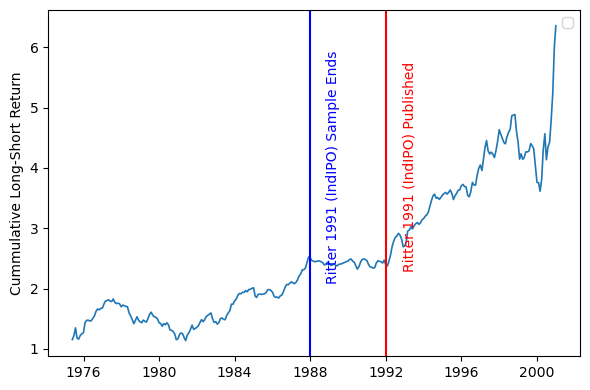

In [5]:
plot_anomaly('IndIPO',plot_end=2000)